# Configs

In [1]:
%load_ext autoreload
%autoreload 3
## other standard packages
import os
import sys
## Env variables and preparation stuffs
sys.path.insert(0, "../")
from src_code.task_utils.config_parser import ConfigParser
configs_dict = {
    "data_configs": {
        "train_path": "../datasets/utn_dataset_curated/part2/train",
        "val_path": "../datasets/utn_dataset_curated/part2/val",
        "test_path": "../datasets/utn_dataset_curated/part2/test",
    "preprocessing_related": {
            "mean": 0.5,  # for raw_image normalisation
            "std": 0.5,  # for raw_image normalisation
            "downscale_factor": 4,
        },
          "dataset_related":
    {"preprocessed_dir": "../datasets/utn_dataset_curated/part2/train/preprocessed",
    "labels_dir": "../datasets/utn_dataset_curated/part2/train/labels",
    "augment": True,
    "shuffle": False},
        "augmentation_related": {
            "flip_prob": 0.5,
            "scale_range": (0.8, 1.2),
            "zoom_prob": 0.3,
            "saturation_prob": 0.2
        },
    },
    "model_configs": {
        "epochs": 1,
        "batch_size": 32,
        "device": "cuda",  # either "cpu" or "cuda"
        "backbone": {
            "name": "VGG16",
            "num_stages": 6,
        },
        "loss": {
            "alpha": 1,  # loss = alpha*loc_loss + cls_loss
            "pos_box_threshold": 0.5,  # a default box is marked positive if it has (> pos_box_threshold) IoU score with any of the groundtruth boxes
            "hard_neg_pos": 3,  # num of negative boxes = hard_neg_pos * num_positive_boxes
        },
        "optim": {
            "name": "SGD",
            "lr": 0.001,
            "momentum": 0.9,
            "weight_decay": 0.0005,
        },
        "scheduler": {
            "name": "MultiStepLR",
            "milestones": [155, 195],
            "gamma": 0.1,
        },
    },
    "task_configs": {
        "img_height": 160,  # original image height
        "img_width": 640,  # original image width
        "debug": True,  # if True will display a lot of intermediate information for debugging purposes
        "log_expt": False,  # whether to log the experiment online or not
        "num_classes": 37,  # A-Z(26), 0-9(10), background(1)
        "min_cls_score": 0.01,  # if the cls score for a bounding box is less than this, it is considered as background
        "nms_iou_score": 0.1,  # if the iou between two bounding boxes is less than this, it is suppressed
    },
}
# hyperparameters
preprocessed_dir = "../datasets/utn_dataset_curated/part2/test/preprocessed"
labels_dir = "../datasets/utn_dataset_curated/part2/train/labels"

# Imports

In [2]:
import torch

In [3]:
config = ConfigParser(configs_dict).get_parser()
# this object can be used as follows:
print(f"{config.pos_box_threshold = }")

config = {'data_configs': {'train_path': '../datasets/utn_dataset_curated/part2/train', 'val_path': '../datasets/utn_dataset_curated/part2/val', 'test_path': '../datasets/utn_dataset_curated/part2/test', 'preprocessing_related': {'mean': 0.5, 'std': 0.5, 'downscale_factor': 4}, 'dataset_related': {'preprocessed_dir': '../datasets/utn_dataset_curated/part2/train/preprocessed', 'labels_dir': '../datasets/utn_dataset_curated/part2/train/labels', 'augment': True, 'shuffle': False}, 'augmentation_related': {'flip_prob': 0.5, 'scale_range': (0.8, 1.2), 'zoom_prob': 0.3, 'saturation_prob': 0.2}}, 'model_configs': {'epochs': 1, 'batch_size': 32, 'device': 'cuda', 'backbone': {'name': 'VGG16', 'num_stages': 6}, 'loss': {'alpha': 1, 'pos_box_threshold': 0.5, 'hard_neg_pos': 3}, 'optim': {'name': 'SGD', 'lr': 0.001, 'momentum': 0.9, 'weight_decay': 0.0005}, 'scheduler': {'name': 'MultiStepLR', 'milestones': [155, 195], 'gamma': 0.1}}, 'task_configs': {'img_height': 160, 'img_width': 640, 'debug':

In [4]:
# note: change to relative import using a dot (.) in datautils line 4 & 5

# 0. Dataloader

In [5]:
print(sys.path)
from src_code.data_utils.dataset_utils import CaptchaDataset, get_dataloader
from src_code.data_utils.augmentation import Augmentations
# if the preprocessed dataset is not available, run create it using src_code/data_utils/preprocessing.py

# Create dataset
dataset = CaptchaDataset(config)

# Load a sample
image, bboxes, labels = dataset[0]

print("Image Shape:", image.shape)
print("Bounding Boxes:", bboxes)
print("Labels:", labels)


# Create DataLoader
dataloader = get_dataloader(dataset, config)

# Load a single batch
images, bboxes, labels = next(iter(dataloader))

# Print batch info
print(f"Batch Image Shape: {images.shape}")
print(f"Bounding Boxes (First Image): {bboxes[0]}")
print(f"Labels (First Image): {labels[0]}")

['../', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/var/lit2425/jenga/suman/pjf/computer_vision/captcha_env/lib/python3.10/site-packages']
Image Shape: torch.Size([1, 40, 160])
Bounding Boxes: tensor([[0.7827, 0.2282, 0.9045, 0.7207],
        [0.3955, 0.0642, 0.5355, 0.6150],
        [0.1053, 0.1678, 0.2042, 0.5652]])
Labels: tensor([21,  0, 33])
Batch Image Shape: torch.Size([2, 1, 40, 160])
Bounding Boxes (First Image): tensor([[0.7827, 0.2282, 0.9045, 0.7207],
        [0.3955, 0.0642, 0.5355, 0.6150],
        [0.1053, 0.1678, 0.2042, 0.5652]])
Labels (First Image): tensor([21,  0, 33])


# 1. Model

In [6]:
from src_code.model_utils.ssd import SSDCaptcha

# Instantiate the SSD model with grayscale input
ssd_model = SSDCaptcha(num_classes=config.num_classes)

# Move model to the appropriate device
# device = torch.device(config['model_configs']['device'])  # CUDA
device = torch.device('cpu')  # Troubles with CUDA, using CPU
ssd_model.to(device)

SSDCaptcha(
  (backbone): VGG16Backbone(
    (conv1_1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv4_1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4_2): Conv2d(512, 512, kernel

## 1.1 Model Architecture

In [7]:
# from torchsummary import summary

# Display model summary
# summary(ssd_model, input_size=(1, 300, 300))  # Grayscale input: 1 channel

## 1.2 Loss Function

In [47]:
from src_code.model_utils.loss import MultiBoxLoss
default_boxes = torch.Tensor([[0.5000, 0.1250, 0.5000, 0.1250],[0.5000, 0.3750, 0.5000, 0.1250],
        [0.5000, 0.6250, 0.5000, 0.1250],[0.5000, 0.8750, 0.5000, 0.1250],
        [0.5000, 0.1250, 0.5000, 0.0625],[0.5000, 0.3750, 0.5000, 0.0625],
        [0.5000, 0.6250, 0.5000, 0.0625],[0.5000, 0.8750, 0.5000, 0.0625]])
# (1, 8, 4)
locs_pred = torch.Tensor([[[0., 0., 0., 0.],
                     [0., 0., 0., 0.],
                     [0., 0., 0., 0.],
                     [0., 0., 0., 0.],
                     [0., 0., 0., 0.],
                     [0., 0., 0., 0.],
                     [0., 0., 0., 0.],
                     [0., 0., 0., 0.]]])

# (1, 8, 36)
cls_pred = torch.Tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
     [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
     [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
     [0.0000, 0.0000, 0.0000, 0.0000, 0.9000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
     [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
     [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
     [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
     [0.0000, 0.0000, 0.0000, 0.0000, 0.9000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
      0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]])
boxes = torch.Tensor([[[ 61,  36, 139, 115], [297,  10, 386,  98], [509,  26, 572,  90]]])
labels = torch.Tensor([[21,  0, 33]])

# calculate loss
mbl = MultiBoxLoss(default_boxes, config)
loss, debug_info = mbl(locs_pred, cls_pred, boxes, labels)
expected_loss = 10.8635

overlap.shape = torch.Size([3, 8])
labels[i] = tensor([21.,  0., 33.]), tensor([2, 0, 0, 0, 0, 0, 0, 0])


In [48]:
loss

tensor(3885.4417)

In [49]:
debug_info

{'overlap_gt_def_boxes': [tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.]])],
 'db_for_each_obj': [tensor([0, 0, 0])],
 'db_indices_for_each_obj': [tensor([0, 0, 0])],
 'overlap_value_for_each_db': tensor([1., 0., 0., 0., 0., 0., 0., 0.]),
 'self.label_each_db': [tensor([33., 36., 36., 36., 36., 36., 36., 36.])],
 'match': [tensor([ True, False, False, False, False, False, False, False])],
 'matched_gt_boxes': [tensor([[0.2500, 0.0625, 0.7500, 0.1875],
          [0.2500, 0.0625, 0.7500, 0.1875],
          [0.2500, 0.0625, 0.7500, 0.1875]])],
 'gt_locs': [tensor([[10800.0000,  4630.0000,    24.1814,    31.1916],
          [ 1990.0000,  6010.0000,    25.2493,    32.2444],
          [ 1990.0000,  5990.0000,    25.2493,    32.2444],
          [ 1990.0000,  5970.0000,    25.2493,    32.2444],
          [ 1990.0000, 12060.0000,    25.2493,    35.7102],
          [ 1990.0000, 12020.0000,    25.2493,    35.7102],


## Visualising the matched gt boxes

In [50]:
import torch
from torchvision.utils import draw_bounding_boxes
import matplotlib.pyplot as plt

Image Shape: torch.Size([1, 40, 160])
Bounding Boxes: tensor([[0.7827, 0.2282, 0.9045, 0.7207],
        [0.3955, 0.0642, 0.5355, 0.6150],
        [0.1053, 0.1678, 0.2042, 0.5652]])
Labels: tensor([21,  0, 33])
img_height = 40 img_width = 160
BBoxes for Visualization: tensor([[125,   9, 144,  28],
        [ 63,   2,  85,  24],
        [ 16,   6,  32,  22]], dtype=torch.int32)


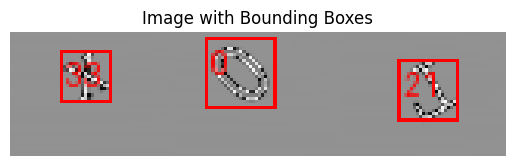

In [93]:
# dataset = CaptchaDataset(preprocessed_dir, labels_dir, downscale_factor=False, augment=True)
# Load one sample for visualization
image, bboxes, labels = dataset[0]

print("Image Shape:", image.shape)
print("Bounding Boxes:", bboxes)
print("Labels:", labels)


def plot_image_with_bboxes(image, bboxes, labels, title="Image with Bounding Boxes"):
    img_height, img_width = image.shape[1], image.shape[2] 
    print(f"{img_height = }", f"{img_width = }")
    # Scale normalized bboxes to absolute pixel values for visualization
    # TODO: --> * 4 used for non flipped images: works
    # Issue with flipped ones
    # How to test: set flip prob to one and you will see :)
    bboxes[:, [0, 2]] *= img_width
    bboxes[:, [1, 3]] *= img_height

    # Convert to integer values for plotting
    bboxes_abs = bboxes.to(torch.int)

    print("BBoxes for Visualization:", bboxes_abs)

    # Ensure labels are strings
    if isinstance(labels, torch.Tensor):
        labels = labels.tolist()
        labels = [str(l) for l in labels]

    # TODO: Image to RGB

    # Draw bboxes
    image_with_boxes = draw_bounding_boxes(image, bboxes_abs, labels=labels, colors="red", width=1)

    # image tensor to NumPy for visualization
    img = image_with_boxes.permute(1, 2, 0).numpy()

    plt.imshow(img)
    plt.axis("off")
    plt.title(title)
    plt.show()


plot_image_with_bboxes(image, bboxes, labels)


In [94]:
test_input = torch.randn(1, 1, 40, 160)  # Maintain rectangular aspect ratio
pred_locs, pred_cls, fm_info = ssd_model(test_input)
print(f"Localization Output Shape: {pred_locs.shape}")
print(f"Classification Output Shape: {pred_cls.shape}")
print(f"fm_info: {fm_info = }")
# Generating default boxes for different feature maps
feature_map_shapes = fm_info.values()  # Example feature map sizes for rectangular input
raw_db = ssd_model.generate_default_boxes()
print(raw_db.shape)

Localization Output Shape: torch.Size([1, 8520, 4])
Classification Output Shape: torch.Size([1, 8520, 37])
fm_info: fm_info = {'conv2_2': [20, 80], 'conv3_3': [10, 40], 'conv8_2_feats': [5, 20], 'conv9_2_feats': [3, 10]}
torch.Size([8520, 4])


In [95]:
boxes

tensor([[[1.5616e+06, 9.2160e+05, 3.5584e+06, 2.9440e+06],
         [2.9700e+02, 1.0000e+01, 3.8600e+02, 9.8000e+01],
         [1.3030e+07, 6.6560e+05, 1.4643e+07, 2.3040e+06]]])

img_height = 40 img_width = 160
BBoxes for Visualization: tensor([[73,  0, 89,  9]], device='cuda:0', dtype=torch.int32)


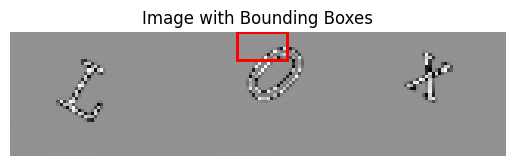

img_height = 40 img_width = 160
BBoxes for Visualization: tensor([[75,  0, 91,  9]], device='cuda:0', dtype=torch.int32)


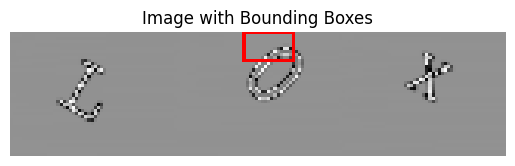

img_height = 40 img_width = 160
BBoxes for Visualization: tensor([[77,  0, 93,  9]], device='cuda:0', dtype=torch.int32)


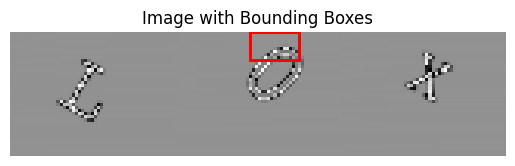

In [132]:
from src_code.model_utils.utils import cxcy_to_xy
for i in range(len(raw_db)):
    bb_ = cxcy_to_xy(raw_db[5000 + i].unsqueeze(0))
    plot_image_with_bboxes(image, bb_, labels=None)
    if i == 2:
        break

In [145]:
image, bboxes, labels = dataset[0]
print(f"{bboxes = }")
mbl = MultiBoxLoss(raw_db, config)
loss, debug_info = mbl(pred_locs, pred_cls, [bboxes], labels.unsqueeze(0))

bboxes = tensor([[0.4817, 0.0000, 0.7199, 0.7218],
        [0.0000, 0.0000, 0.1561, 0.6352]])
boxes = [tensor([[0.4817, 0.0000, 0.7199, 0.7218],
        [0.0000, 0.0000, 0.1561, 0.6352]])]


AssertionError: 

In [142]:
debug_info

{'overlap_gt_def_boxes': [tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0814, 0.0814, 0.0814],
          [0.0000, 0.0000, 0.0000,  ..., 0.0234, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])],
 'db_for_each_obj': [tensor([6593, 8029, 6526])],
 'db_indices_for_each_obj': [tensor([6593, 8029, 6526])],
 'overlap_value_for_each_db': tensor([0.0000, 0.0000, 0.0000,  ..., 0.0814, 0.0814, 0.0814]),
 'self.label_each_db': [tensor([36, 36, 36,  ..., 36, 36, 36])],
 'match': [tensor([False, False, False,  ..., False, False, False])],
 'matched_gt_boxes': [tensor([[ 0.7875,  0.2500,  0.8875,  0.6500],
          [ 0.3875, -0.0500,  0.5625,  0.6500],
          [ 0.1125,  0.1500,  0.2125,  0.5500]])],
 'gt_locs': [tensor([[ 1.6748e+02,  2.2473e+01,  4.4519e+00,  4.5063e+00],
          [ 1.6498e+02,  2.2473e+01,  4.4519e+00,  4.5063e+00],
          [ 1.6248e+02,  2.2473e+01,  4.4519e+00,  4.5063e+00],
          ...,
          [ 1.7338e+00, -3.9874e+00, -7.4459e+00, -3.

img_height = 40 img_width = 160
BBoxes for Visualization: tensor([[125,   9, 144,  28],
        [ 63,   2,  85,  24],
        [ 16,   6,  32,  22]], dtype=torch.int32)


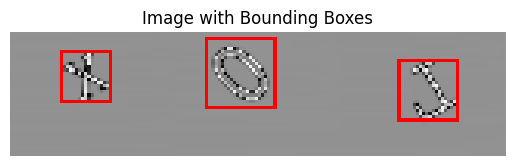

In [143]:
# Load one sample for visualization
image, bboxes, labels = dataset[0]
plot_image_with_bboxes(image, bboxes, labels=None)

img_height = 40 img_width = 160
BBoxes for Visualization: tensor([[125,   9, 142,  26],
        [ 62,  -1,  90,  26],
        [ 18,   5,  34,  22]], dtype=torch.int32)


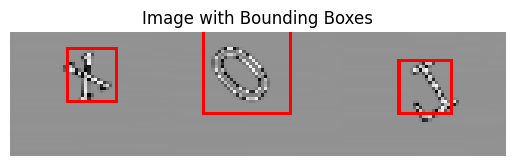

In [144]:
plot_image_with_bboxes(image, debug_info['matched_gt_boxes'][0], labels=None)

# 2. Training

# 3. Evaluation